In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Analysis

In [2]:
df=pd.read_csv("sentiment.csv")
df.head()

,Phrase,label
0,Spider-man is better than any summer blockbust...,Positive
1,of good sense,Positive
2,", then knock yourself out and enjoy the big sc...",Negative
3,So could young romantics out on a date .,Positive
4,humour,Positive


In [3]:
len(df)

2800

In [36]:
positive_sentence=len(df[df.label=="Positive"])
print(positive_sentence)

1800


In [37]:
negative_sentence=len(df[df.label=="Negative"])
print(negative_sentence)

1000


#  split into Train set,val set and test set


In [5]:
total_len=len(df)
train_len=int(0.6*total_len)
val_len=int(0.2*total_len)
print(train_len,val_len)


1680 560


In [6]:
train_df=df[0:train_len]
val_df=df[train_len:train_len+val_len]
test_df=df[train_len+val_len:]
len(train_df)

1680

In [7]:
vocab=list() 
for i in train_df.Phrase.tolist():
#     print(i)
#     print(i.split(" "))
    vocab.extend(i.split(" "))
# set gives only unique values  
u_vocab=list(set(vocab)) 
# print(len(u_vocab))
print(len(vocab), len(u_vocab))
    

13855 1844


# feature extraction

In [8]:
train_df.head()

,Phrase,label
0,Spider-man is better than any summer blockbust...,Positive
1,of good sense,Positive
2,", then knock yourself out and enjoy the big sc...",Negative
3,So could young romantics out on a date .,Positive
4,humour,Positive


In [9]:

def extract_feature(f_df):
    feature=[]
    label=[]
    for index,row in f_df.iterrows():
    #     print(index,row['Phrase'])
        words=row['Phrase'].split(" ")
        f=[]
        for v in u_vocab:
            if v in words:
                f.append(1)
            else: 
              f.append(0)
        if  row["label"]=="Positive":
            label.append(1)
        elif row["label"]=="Negative":
            label.append(0)    

        feature.append(f)

    #     print(f)

    # #     print(words)
    #     break
    feature=np.array(feature)
    label=np.array(label)
    label=label.reshape(-1,1)
    return feature,label

In [34]:
# x_train

In [10]:
x_train, y_train=extract_feature(train_df)
x_val,y_val=extract_feature(val_df)
x_test,y_test=extract_feature(test_df)


In [28]:
x_train=np.insert(x_train,0,values=1,axis=1)
x_val=np.insert(x_val,0,values=1,axis=1)
x_test=np.insert(x_test,0,values=1,axis=1)

In [35]:
# x_train

## Model Building

In [30]:

def CEL(h,y):
    return (-y*np.log(h)-(1-y)*np.log(1-h)).mean()



In [31]:
np.random.seed(42)

#hyperparameters
params = {
    'number_of_iterations': 1000,
    'learning_rate': 0.001
}

grid_param = {
    'number_of_iterations': [1000, 2000],
    'learning_rate': [0.001,0.1]
}

In [14]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [15]:
np.power(2,4)

16

In [16]:
def train_model(x_train, y_train, x_val, y_val, params):
    W = np.random.rand(x_train.shape[1]).reshape(-1,1)
    train_error = []

    for i in range(1, params['number_of_iterations']):
        z= np.matmul(x_train,W)
        h_train = sigmoid(z)
        
        train_loss = CEL(h_train, y_train)#change
#         print(i, train_loss)
        train_error.append(train_loss)
#         val_error.append(val_loss)
    
        gradient = np.matmul(np.transpose(x_train),(h_train - y_train))/x_train.shape[0]

        W = W - params['learning_rate'] * gradient
    z= np.matmul(x_val,W)#z=wx
    h_val = sigmoid(z)
#     h_val = sigmoid(x_val, W)#change
    val_loss = CEL(h_val, y_val)#change
#     print(h_val, y_val)
    return W, train_error, val_loss
#     print(W, train_error,val_loss)

In [17]:
p = {
        'number_of_iterations': 100,
        'learning_rate': 0.001
    }
    
train_model(x_train,y_train,x_val,y_val,p)

(array([[0.35033572],
        [0.95066787],
        [0.7316061 ],
        ...,
        [0.43935241],
        [0.61282913],
        [0.9430217 ]]),
 [1.6731908096240466,
  1.6730741293774032,
  1.6729574619985952,
  1.672840807485539,
  1.6727241658462244,
  1.6726075370763562,
  1.6724909211747574,
  1.6723743181455022,
  1.6722577279862099,
  1.6721411506942285,
  1.6720245862791758,
  1.671908034732776,
  1.671791496059353,
  1.6716749702585227,
  1.6715584573294404,
  1.671441957272597,
  1.6713254700896023,
  1.6712089957797454,
  1.6710925343442442,
  1.6709760857858842,
  1.6708596501008732,
  1.670743227286396,
  1.67062681735332,
  1.6705104202928076,
  1.670394036108067,
  1.6702776648005966,
  1.6701613063690004,
  1.670044960814112,
  1.669928628136628,
  1.669812308336491,
  1.6696960014150364,
  1.6695797073720422,
  1.6694634262084862,
  1.669347157920691,
  1.6692309025139929,
  1.6691146599851723,
  1.6689984303369212,
  1.668882213568756,
  1.6687660096836798,
  1.6686

In [18]:
#grid search parameter with val loss
import itertools
grid = list(itertools.product(grid_param['number_of_iterations'],grid_param['learning_rate']))
print(grid)

[(1000, 0.001), (1000, 0.1), (2000, 0.001), (2000, 0.1)]


In [19]:
for g in grid:
    p = {
        'number_of_iterations': g[0],
        'learning_rate': g[1]
    }
    
    train_model(x_train, y_train, x_val, y_val,params)

{'number_of_iterations': 1000, 'learning_rate': 0.001}


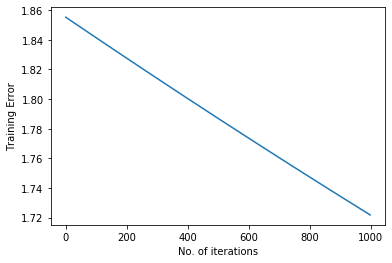

{'number_of_iterations': 1000, 'learning_rate': 0.1}


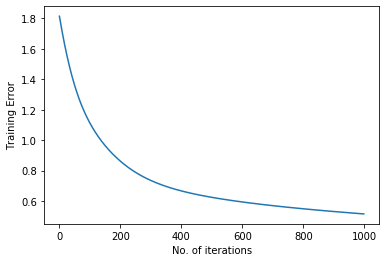

{'number_of_iterations': 2000, 'learning_rate': 0.001}


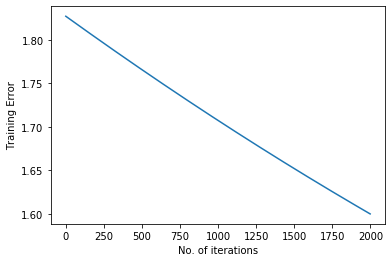

{'number_of_iterations': 2000, 'learning_rate': 0.1}


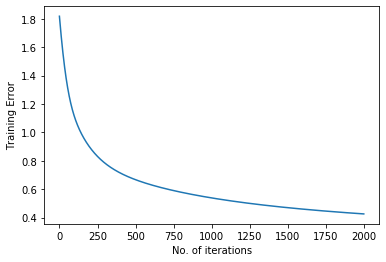

In [20]:
for g in grid:
    p={
    'number_of_iterations':g[0],
    'learning_rate':g[1],

    }
    print(p)
    Weights,train_error,val_error=train_model(x_train,y_train,x_val,y_val,p)
#     print(val_error)
    plt.plot(np.arange(len(train_error)),train_error)
    plt.xlabel("No. of iterations")
    plt.ylabel("Training Error")   
    plt.show()

In [39]:
# def perf_measure(y_actual, y_hat):
#     TP = 0
#     FP = 0
#     TN = 0
#     FN = 0

#     for i in range(len(y_hat)): 
#         if y_actual[i]==y_hat[i]==1:
#             TP += 1
#         if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
#             FP += 1
#         if y_actual[i]==y_hat[i]==0:
#             TN += 1
#         if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
#             FN += 1

#     return(TP, FP, TN, FN)

    

In [40]:
def precision(tp,tn,fp,fn):
    return tp/(tp+fp)

In [41]:
def precision(tp,tn,fp,fn):
    return tp/(tn+fp)

In [42]:
def f1_score(p,r):
    return (p*r)/(p+r)

In [43]:
def confuion_matrix(y,h):
    tp, fp, tn, fn = perf_measure(y,h)
    cm = [[tp,fp],[fn,tn]]
    return cm

In [2]:
# Evaluation
W,train_error,val_error=train_model(x_train,y_train,x_val,y_val,p)
z= np.matmul(x_test,W)#z=wx
h_test = sigmoid(z)
cm = confuion_matrix(y_test,h_test)
print(cm)
tp, fp, tn, fn = perf_measure(y_test,h_test)
print(tp, fp, tn, fn)
# p = precision(tp, fp, tn, fn)
# r = recall(tp, fp, tn, fn)
# f = f1_score(tp, fp, tn, fn)

print("Precision", p)
# print("Recall", r)
print("f1_score", f)
print("Confusion Matrix", cm)

NameError: name 'train_model' is not defined

In [ ]:
+